# Lab 2: BTC Time Series Stationarity Analysis and Decomposition

This notebook performs the tasks outlined in Lab 2:
1.  **Stationarity Check**: Uses statistical tests to check the time series (BTCUSDT close price) for stationarity.
2.  **Time Series Decomposition**: Decomposes the time series into components (trend, seasonality, residuals).

This notebook also includes the necessary steps from Lab 1 for data loading and preparation.

In [1]:
# Cell 1: Imports and Path Setup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import requests
import time
from datetime import datetime, timezone, timedelta
import logging
import os
from statsmodels.tsa.stattools import adfuller # For Dickey-Fuller test
from statsmodels.tsa.seasonal import seasonal_decompose # For decomposition

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style

# --- Path Definitions ---
# Assume the notebook is in PROJECT_ROOT/notebooks/
_NOTEBOOK_CURRENT_DIR = os.getcwd() # This is PROJECT_ROOT/notebooks/
PROJECT_ROOT = os.path.abspath(os.path.join(_NOTEBOOK_CURRENT_DIR, '..'))
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')
LAB2_PLOT_SAVE_DIR = os.path.join(RESULTS_DIR, 'lab_2') # Directory for saving Lab 2 plots

# Create directories if they don't exist
for dir_path in [DATA_DIR, RESULTS_DIR, LAB2_PLOT_SAVE_DIR]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        logging.info(f"Created directory: {dir_path}")

logging.info(f"Project Root: {PROJECT_ROOT}")
logging.info(f"Data directory: {DATA_DIR}")
logging.info(f"Results directory: {RESULTS_DIR}")
logging.info(f"Plot save directory for Lab 2: {LAB2_PLOT_SAVE_DIR}")

2025-05-14 12:53:11,462 - INFO - Created directory: /home/denis/kpi/tsp/results/lab_2
2025-05-14 12:53:11,498 - INFO - Project Root: /home/denis/kpi/tsp
2025-05-14 12:53:11,498 - INFO - Data directory: /home/denis/kpi/tsp/data
2025-05-14 12:53:11,499 - INFO - Results directory: /home/denis/kpi/tsp/results
2025-05-14 12:53:11,499 - INFO - Plot save directory for Lab 2: /home/denis/kpi/tsp/results/lab_2


## Step 1 (from Lab 1): Data Loading and Preparation

We will load the last 5000 hourly OHLCV data points for the BTCUSDT trading pair directly from the Binance API.
We will save this data (or at least the close price) to a CSV file in the `PROJECT_ROOT/data/` directory.
For the analysis in this lab, we will focus on the 'Close' price.

In [2]:
# Cell 2: Helper functions for Binance API interaction (adapted from Lab 1)

# Binance API constants
BINANCE_API_URL = "https://api.binance.com/api/v3/klines"
MAX_KLINE_LIMIT = 1000
REQUEST_TIMEOUT = 15
MAX_RETRIES = 3
RETRY_DELAY = 5

def _ms_to_datetime_utc(ms):
    return datetime.fromtimestamp(ms / 1000, tz=timezone.utc)

def _datetime_to_ms_utc(dt):
    return int(dt.timestamp() * 1000)

def fetch_binance_klines_from_api(symbol, interval, limit=500, end_time_dt=None):
    # This function is identical to the one in Lab 1, Cell 2
    # It loads data from the Binance API
    all_klines_data = []
    records_to_fetch = limit
    current_end_time_ms = _datetime_to_ms_utc(end_time_dt) if end_time_dt else _datetime_to_ms_utc(datetime.now(timezone.utc))

    while records_to_fetch > 0:
        current_limit = min(records_to_fetch, MAX_KLINE_LIMIT)
        params = {
            'symbol': symbol,
            'interval': interval,
            'limit': current_limit,
            'endTime': current_end_time_ms
        }
        logging.info(f"Fetching {current_limit} klines for {symbol}, ending at or before {pd.to_datetime(params.get('endTime'), unit='ms', utc=True)}")
        for attempt in range(MAX_RETRIES):
            try:
                response = requests.get(BINANCE_API_URL, params=params, timeout=REQUEST_TIMEOUT)
                response.raise_for_status()
                klines_chunk = response.json()
                if not klines_chunk:
                    logging.info(f"API returned no more data for {symbol} with endTime {current_end_time_ms}.")
                    records_to_fetch = 0
                    break
                all_klines_data = klines_chunk + all_klines_data
                records_to_fetch -= len(klines_chunk)
                current_end_time_ms = klines_chunk[0][0] - 1
                break
            except requests.exceptions.Timeout:
                logging.warning(f"Timeout fetching {symbol}. Attempt {attempt+1}/{MAX_RETRIES}. Retrying in {RETRY_DELAY}s...")
            except requests.exceptions.RequestException as e:
                status_code = e.response.status_code if e.response is not None else None
                if status_code in [429, 418]:
                    rate_limit_delay = RETRY_DELAY * (attempt + 2)
                    logging.warning(f"Rate limit hit (Status: {status_code}) for {symbol}. Attempt {attempt+1}/{MAX_RETRIES}. Retrying after {rate_limit_delay}s...")
                    time.sleep(rate_limit_delay)
                else:
                    logging.warning(f"Request failed for {symbol}: {e}. Status: {status_code}. Attempt {attempt+1}/{MAX_RETRIES}. Retrying...")
            except Exception as e:
                logging.error(f"Unexpected error fetching {symbol}: {e}", exc_info=True)
                df_partial = pd.DataFrame()
                if all_klines_data:
                     columns_temp = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
                     df_partial = pd.DataFrame(all_klines_data, columns=columns_temp)
                return df_partial
            if attempt < MAX_RETRIES - 1:
                time.sleep(RETRY_DELAY)
            else:
                logging.error(f"Failed to fetch data chunk for {symbol} after {MAX_RETRIES} attempts.")
                df_partial_fail = pd.DataFrame()
                if all_klines_data:
                     columns_temp_fail = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
                     df_partial_fail = pd.DataFrame(all_klines_data, columns=columns_temp_fail)
                return df_partial_fail
        if not klines_chunk and records_to_fetch > 0:
            logging.warning(f"API returned no more data for {symbol}, but {records_to_fetch} records were still expected.")
            break
    if not all_klines_data:
        logging.warning(f"No klines fetched for {symbol}.")
        return pd.DataFrame()
    columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
    df = pd.DataFrame(all_klines_data, columns=columns)
    df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', utc=True)
    df.set_index('Open time', inplace=True)
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.sort_index(inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df.tail(limit)

In [3]:
# Cell 3: Fetching the last 5000 hourly BTCUSDT data points and saving
SYMBOL = 'BTCUSDT'
INTERVAL = '1h'
DATA_POINTS_TO_FETCH = 5000

logging.info(f"Fetching last {DATA_POINTS_TO_FETCH} hourly data points for {SYMBOL} from API...")
btc_ohlcv_df = fetch_binance_klines_from_api(SYMBOL, INTERVAL, limit=DATA_POINTS_TO_FETCH)

if not btc_ohlcv_df.empty and len(btc_ohlcv_df) == DATA_POINTS_TO_FETCH:
    logging.info(f"Successfully fetched {len(btc_ohlcv_df)} BTCUSDT data points. Shape: {btc_ohlcv_df.shape}")
    
    # For Lab 2, we will use only the 'Close' price
    btc_close_series = btc_ohlcv_df['Close'].copy()
    print("Sample data (first 5 rows of 'Close' prices):")
    print(btc_close_series.head())

    # Saving the fetched data (close price)
    timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename_ohlcv = f"{SYMBOL.lower()}_ohlcv_hourly_last{DATA_POINTS_TO_FETCH}_{timestamp_str}.csv"
    filepath_ohlcv = os.path.join(DATA_DIR, filename_ohlcv)
    filename_close = f"{SYMBOL.lower()}_close_hourly_last{DATA_POINTS_TO_FETCH}_{timestamp_str}.csv"
    filepath_close = os.path.join(DATA_DIR, filename_close)
    try:
        btc_ohlcv_df.to_csv(filepath_ohlcv)
        logging.info(f"Full OHLCV data saved to: {filepath_ohlcv}")
        btc_close_series.to_csv(filepath_close, header=True)
        logging.info(f"'Close' price data saved to: {filepath_close}")
    except Exception as e:
        logging.error(f"Failed to save data to CSV: {e}")
elif not btc_ohlcv_df.empty:
    logging.warning(f"Fetched {len(btc_ohlcv_df)} data points, but expected {DATA_POINTS_TO_FETCH}. Using fetched data.")
    btc_close_series = btc_ohlcv_df['Close'].copy()
    print(f"Fetched {len(btc_ohlcv_df)} data points, but expected {DATA_POINTS_TO_FETCH}.")
    print(btc_close_series.head())
else:
    logging.error(f"Failed to fetch sufficient data for {SYMBOL}.")
    btc_close_series = pd.Series(dtype=float) # Create an empty series if fetching fails

2025-05-14 12:54:25,754 - INFO - Fetching last 5000 hourly data points for BTCUSDT from API...
2025-05-14 12:54:25,755 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2025-05-14 09:54:25.755000+00:00
2025-05-14 12:54:26,082 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2025-04-02 17:59:59.999000+00:00
2025-05-14 12:54:26,403 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2025-02-20 01:59:59.999000+00:00
2025-05-14 12:54:26,722 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2025-01-09 09:59:59.999000+00:00
2025-05-14 12:54:27,052 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2024-11-28 17:59:59.999000+00:00
2025-05-14 12:54:27,373 - INFO - Successfully fetched 5000 BTCUSDT data points. Shape: (5000, 5)
2025-05-14 12:54:27,399 - INFO - Full OHLCV data saved to: /home/denis/kpi/tsp/data/btcusdt_ohlcv_hourly_last5000_20250514_125427.csv
2025-05-14 12:54:27,411 - INFO - 'Close' price data saved to: /home/denis/

Sample data (first 5 rows of 'Close' prices):
Open time
2024-10-18 02:00:00+00:00    68103.99
2024-10-18 03:00:00+00:00    67555.40
2024-10-18 04:00:00+00:00    67742.72
2024-10-18 05:00:00+00:00    68000.79
2024-10-18 06:00:00+00:00    68108.00
Name: Close, dtype: float64


## Step 2 (from Lab 1): Visualizing the Time Series (Close Price)

We will display the time series of the BTCUSDT close price. The plot will be saved in `PROJECT_ROOT/results/lab_2/`.

2025-05-14 12:55:02,512 - INFO - Close price plot saved as /home/denis/kpi/tsp/results/lab_2/lab2_plot_btcusdt_close_price.png


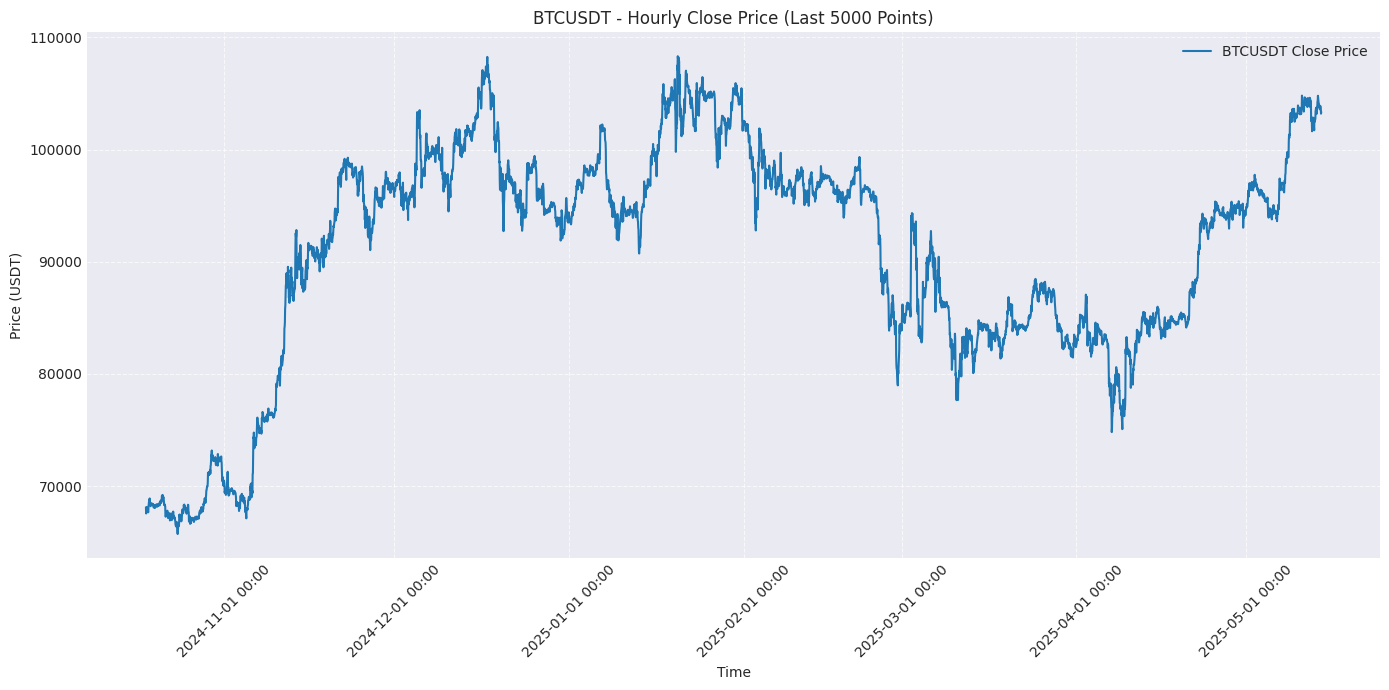

In [4]:
# Cell 4: Visualizing the 'Close' price

if not btc_close_series.empty:
    plt.figure(figsize=(14, 7))
    plt.plot(btc_close_series.index, btc_close_series, label=f'{SYMBOL} Close Price')
    plt.title(f'{SYMBOL} - Hourly Close Price (Last {len(btc_close_series)} Points)')
    plt.xlabel('Time')
    plt.ylabel('Price (USDT)')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    plot_filename = f"lab2_plot_{SYMBOL.lower()}_close_price.png"
    plot_filepath = os.path.join(LAB2_PLOT_SAVE_DIR, plot_filename)
    try:
        plt.savefig(plot_filepath)
        logging.info(f"Close price plot saved as {plot_filepath}")
    except Exception as e:
        logging.error(f"Could not save close price plot: {e}")
    plt.show()
else:
    logging.warning("'btc_close_series' is empty. Skipping visualization.")

## Lab 2 - Task 1: Checking Time Series for Stationarity

We will use the Augmented Dickey-Fuller (ADF) test to check the stationarity of the BTC close price series.

**Null Hypothesis (H0)**: The time series has a unit root (it is non-stationary).
**Alternative Hypothesis (H1)**: The time series does not have a unit root (it is stationary).

We reject the null hypothesis if the p-value is less than a certain significance level (e.g., 0.05).

In [5]:
# Cell 5: Checking for stationarity using the ADF test

if not btc_close_series.empty:
    logging.info("--- Checking for Stationarity (ADF Test) ---")
    
    # Remove potential NaN values that might occur at the beginning of the series after .rolling() or if data is incomplete
    adf_series = btc_close_series.dropna()

    if adf_series.empty:
        logging.warning("Data series is empty after dropping NaN. Skipping ADF test.")
    else:
        result_adf = adfuller(adf_series)
        
        print(f'ADF Statistic: {result_adf[0]}')
        print(f'p-value: {result_adf[1]}')
        print('Critical Values:')
        for key, value in result_adf[4].items():
            print(f'\t{key}: {value}')

        if result_adf[1] <= 0.05:
            print("\nResult: The series is likely stationary (reject H0).")
            logging.info("ADF test: The series is likely stationary.")
        else:
            print("\nResult: The series is likely non-stationary (fail to reject H0).")
            logging.info("ADF test: The series is likely non-stationary.")
            
        # Additional information for the report
        print(f"\nNumber of observations for ADF test: {result_adf[3]}")
        print(f"Method for determining the number of lags: {result_adf[2]}")
        print(f"Information criterion (AIC) if used for lag selection: {result_adf[5] if len(result_adf) > 5 else 'N/A'}")

else:
    logging.warning("'btc_close_series' is empty. Skipping ADF test.")

2025-05-14 12:56:08,522 - INFO - --- Checking for Stationarity (ADF Test) ---
2025-05-14 12:56:08,609 - INFO - ADF test: The series is likely non-stationary.


ADF Statistic: -2.1126166993632904
p-value: 0.23947172026194324
Critical Values:
	1%: -3.4316645822626564
	5%: -2.8621209026179866
	10%: -2.567079215269484

Result: The series is likely non-stationary (fail to reject H0).

Number of observations for ADF test: 4977
Method for determining the number of lags: 22
Information criterion (AIC) if used for lag selection: 76113.30475172153


## Lab 2 - Task 2: Time Series Decomposition

Decomposition allows us to break down the time series into several components:
-   **Trend**: The long-term direction of the series.
-   **Seasonality**: Periodic fluctuations (e.g., daily, weekly).
-   **Residuals**: What remains after removing the trend and seasonality (random noise).

We will use an additive decomposition model, as financial series often have fluctuations whose amplitude does not strongly depend on the series level. If the amplitude of seasonal fluctuations grew with the series level, a multiplicative model would be more appropriate.

For hourly BTC data, daily seasonality (period 24) is a typical assumption.

2025-05-14 12:57:52,444 - INFO - --- Decomposing the Time Series ---
2025-05-14 12:57:52,752 - INFO - Additive decomposition plot saved as /home/denis/kpi/tsp/results/lab_2/lab2_plot_btcusdt_decomposition_additive.png


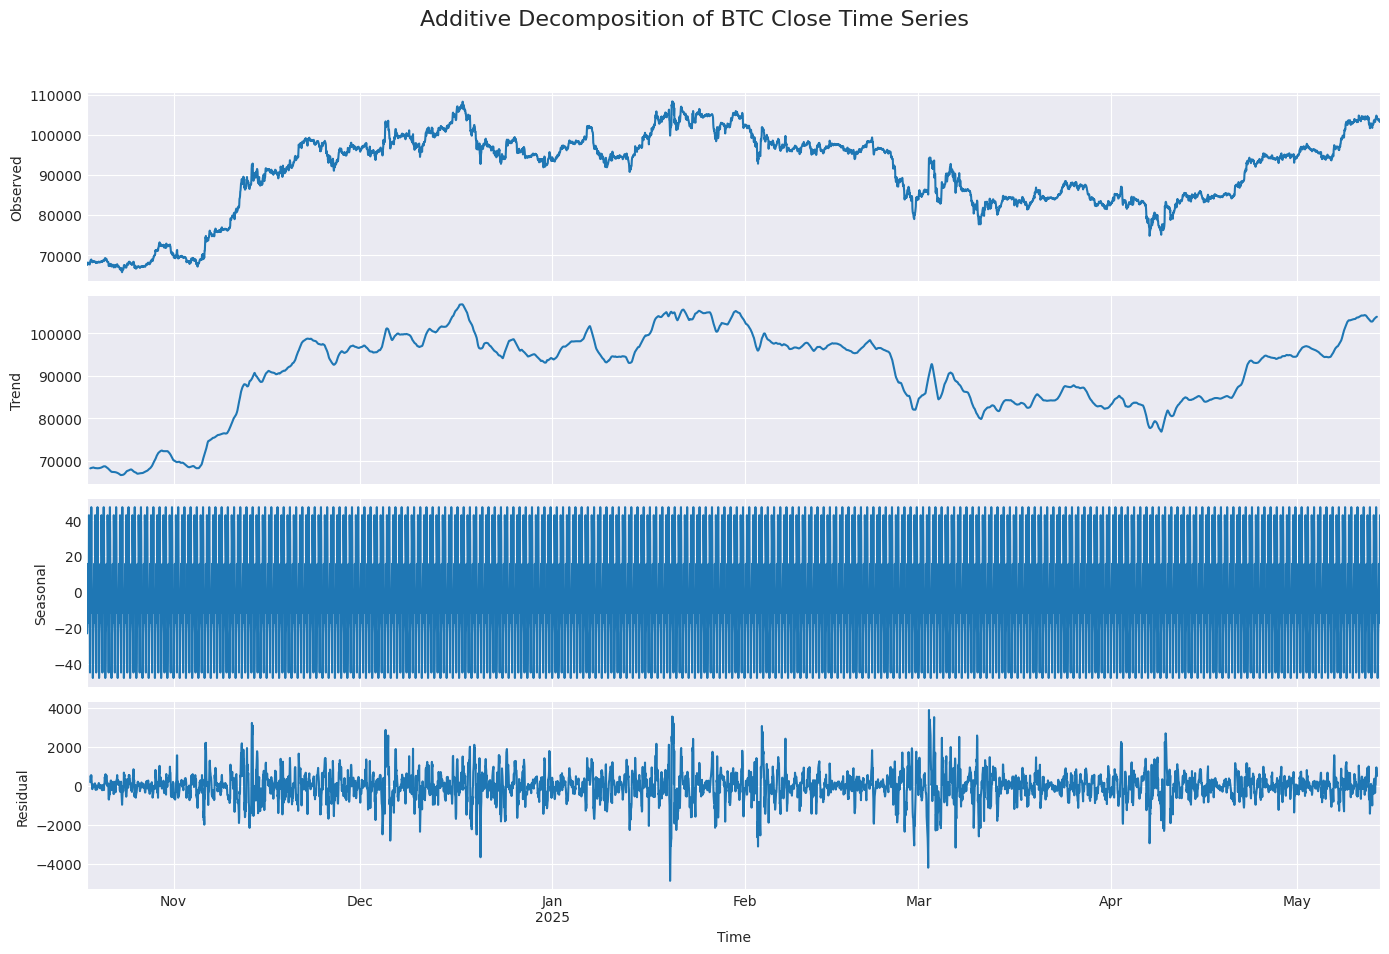


Component Statistics (Additive Model):
  Trend: Mean = 90856.21, Standard Deviation = 9965.78
  Seasonality: Mean = -0.00, Standard Deviation = 25.56
  Residuals: Mean = 0.60, Standard Deviation = 719.10


In [6]:
# Cell 6: Decomposing the time series

if not btc_close_series.empty:
    logging.info("--- Decomposing the Time Series ---")
    
    # Remove potential NaN values
    decomposition_series = btc_close_series.dropna()

    # Period for seasonality (24 hours for daily seasonality)
    # seasonal_decompose requires at least 2 full cycles, so series length must be > 2 * period
    period = 24 
    
    if len(decomposition_series) > 2 * period:
        # Additive decomposition
        decomposition_additive = seasonal_decompose(decomposition_series, model='additive', period=period)

        # Multiplicative decomposition (for comparison or if assumed)
        # decomposition_multiplicative = seasonal_decompose(decomposition_series, model='multiplicative', period=period)

        fig_additive, (ax_obs_add, ax_trend_add, ax_seasonal_add, ax_resid_add) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

        decomposition_additive.observed.plot(ax=ax_obs_add, legend=False)
        ax_obs_add.set_ylabel('Observed')
        decomposition_additive.trend.plot(ax=ax_trend_add, legend=False)
        ax_trend_add.set_ylabel('Trend')
        decomposition_additive.seasonal.plot(ax=ax_seasonal_add, legend=False)
        ax_seasonal_add.set_ylabel('Seasonal')
        decomposition_additive.resid.plot(ax=ax_resid_add, legend=False)
        ax_resid_add.set_ylabel('Residual')
        
        fig_additive.suptitle('Additive Decomposition of BTC Close Time Series', fontsize=16)
        plt.xlabel('Time')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Saving the decomposition plot
        decomp_plot_filename = f"lab2_plot_{SYMBOL.lower()}_decomposition_additive.png"
        decomp_plot_filepath = os.path.join(LAB2_PLOT_SAVE_DIR, decomp_plot_filename)
        try:
            plt.savefig(decomp_plot_filepath)
            logging.info(f"Additive decomposition plot saved as {decomp_plot_filepath}")
        except Exception as e:
            logging.error(f"Could not save decomposition plot: {e}")
        plt.show()
        
        # Printing some statistics for the report
        print("\nComponent Statistics (Additive Model):")
        if not decomposition_additive.trend.empty: # Check if trend is not all NaNs
            print(f"  Trend: Mean = {decomposition_additive.trend.mean():.2f}, Standard Deviation = {decomposition_additive.trend.std():.2f}")
        if not decomposition_additive.seasonal.empty:
            print(f"  Seasonality: Mean = {decomposition_additive.seasonal.mean():.2f}, Standard Deviation = {decomposition_additive.seasonal.std():.2f}")
        if not decomposition_additive.resid.empty: # Check if residual is not all NaNs
            print(f"  Residuals: Mean = {decomposition_additive.resid.mean():.2f}, Standard Deviation = {decomposition_additive.resid.std():.2f}")

    else:
        logging.warning(f"Not enough data for decomposition with period {period} (need > {2*period}, have {len(decomposition_series)}).")
        print(f"Not enough data for decomposition with period {period}.")

else:
    logging.warning("'btc_close_series' is empty. Skipping decomposition.")

---
## Lab 2 - Conclusion

In this lab, the following was performed:
1.  **Data Loaded and Prepared**: The last 5000 hourly BTCUSDT close prices were loaded and saved.
2.  **Time Series Visualized**: The close price time series was plotted.
3.  **Stationarity Checked**: The Augmented Dickey-Fuller (ADF) test was used to analyze the stationarity of the series. Test results (ADF statistic, p-value, critical values) were output. The series was confirmed to be non-stationary, as is typicaly for financial price time series.
4.  **Decomposition Performed**: The close price time series was decomposed into trend, seasonality (with a 24-hour period), and residual components using an additive model. Plots of these components were generated and saved.

All plots and key statistical indicators have been saved for inclusion in the report.
---